In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import scipy.sparse
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import numpy as np
from datetime import datetime
import tensorflow_datasets as tfds
import IPython
import IPython.display


In [1]:
%run InitialDataCleanup_Ratawfiq11042021.ipynb
IPython.display.clear_output()

In [18]:
df = result
df.tail()

,initclaims_count_regular,contclaims_count_regular,initclaims_count_combined,contclaims_count_combined,bg_posts_ss60,bg_posts_ss70,case_count,death_count,revenue_ss60,revenue_ss70,spend_acf,spend_hcs,gps_retail_and_recreation,gps_grocery_and_pharmacy,gps_transit_stations,gps_workplaces,gps_away_from_home
2021-03-02,11452.428571,169619.714286,15360.0,301818.285714,-0.093543,-0.121143,613391.0,16067.0,-0.400,-0.599,-0.136,-0.0876,-0.174,-0.0943,-0.273,-0.229,-0.0952
2021-03-03,11437.571429,166754.285714,15299.0,226363.714286,-0.103029,-0.126429,614731.0,16090.0,-0.404,-0.605,-0.146,-0.0794,-0.163,-0.0857,-0.264,-0.229,-0.0936
2021-03-04,11422.714286,163888.857143,15238.0,150909.142857,-0.112514,-0.131714,616099.0,16112.0,-0.410,-0.609,-0.153,-0.0647,-0.159,-0.0843,-0.263,-0.229,-0.0936
2021-03-05,11407.857143,161023.428571,15177.0,75454.571429,-0.122000,-0.137000,617541.0,16135.0,-0.359,-0.612,-0.130,0.0041,-0.156,-0.0829,-0.261,-0.229,-0.0936
2021-03-06,11393.000000,158158.000000,15116.0,0.000000,-0.122000,-0.137000,619020.0,16156.0,-0.367,-0.613,-0.118,0.0255,-0.153,-0.0814,-0.260,-0.227,-0.0936


## The newly added columns - to give us ideas of how and when covid-19 cases are reducing and economy is picking up are;

**1.) gps_retail_and_recreation	
2.) gps_grocery_and_pharmacy	
3.) gps_transit_stations	
4.) gps_workplaces and
5.) gps_away_from_home**

In [19]:
#target_names = ['contclaims_count_regular']
target_names = list(df.columns)

In [20]:
split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 20
future = 1
learning_rate = 0.001
batch_size = 12

sequence_length = int(past / step)

In [21]:
titles = list(df.columns)
features = df[titles]
features.head()

,initclaims_count_regular,contclaims_count_regular,initclaims_count_combined,contclaims_count_combined,bg_posts_ss60,bg_posts_ss70,case_count,death_count,revenue_ss60,revenue_ss70,spend_acf,spend_hcs,gps_retail_and_recreation,gps_grocery_and_pharmacy,gps_transit_stations,gps_workplaces,gps_away_from_home
2020-03-07,5150.000000,77661.0,5150.000000,77661.0,0.072643,0.0837,0.0,0.0,0.0546,-0.0413,-0.03040,-0.02080,0.1070,0.0471,0.1070,0.0257,0.0156
2020-03-08,5176.857143,77389.0,5176.857143,77389.0,0.063086,0.0714,0.0,0.0,0.1010,-0.0357,-0.02830,0.00586,0.1070,0.0486,0.0943,0.0257,0.0156
2020-03-09,5203.714286,77117.0,5203.714286,77117.0,0.053529,0.0591,0.0,0.0,0.0707,-0.0370,-0.02430,-0.04010,0.1030,0.0486,0.0914,0.0257,0.0139
2020-03-10,5230.571429,76845.0,5230.571429,76845.0,0.043971,0.0468,0.0,0.0,0.0271,-0.0430,-0.00913,0.18600,0.1010,0.0457,0.0871,0.0229,0.0125
2020-03-11,5257.428571,76573.0,5257.428571,76573.0,0.034414,0.0345,1.0,0.0,0.0279,-0.0489,-0.01250,0.15600,0.0957,0.0586,0.0800,0.0229,0.0109


In [22]:
start = past + future
end = start + train_split

x_data = features.values[0: -start]
y_data = features[target_names].values[start:]

x_train = x_data[:train_split]
x_val = x_data[train_split:]

y_train = y_data[:train_split]
y_val = y_data[train_split:]

x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_val_scaled = x_scaler.transform(x_val)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)

len(x_train) + len(x_val), len(y_train) + len(y_val), len(features)

(344, 344, 365)

In [23]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train_scaled,
    y_train_scaled,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [24]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val_scaled,
    y_val_scaled,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [25]:
for batch in dataset_train.take(1):
    inputs, targets = batch
print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

print('dataset val')
i = 0
for j in dataset_val:
    x, y = j
    print('x shape:', x.shape)
    print('y shape:', y.shape)
    i = i + 1

print(f'length of x_val: {len(x_val)}')
print(f'length of validation data: {len(dataset_val)}')
print(f'number of batches: {i}')

Input shape: (12, 20, 17)
Target shape: (12, 17)
dataset val
x shape: (12, 20, 17)
y shape: (12, 17)
x shape: (12, 20, 17)
y shape: (12, 17)
x shape: (12, 20, 17)
y shape: (12, 17)
x shape: (12, 20, 17)
y shape: (12, 17)
x shape: (12, 20, 17)
y shape: (12, 17)
x shape: (10, 20, 17)
y shape: (10, 17)
length of x_val: 89
length of validation data: 6
number of batches: 6


# Tuning some hyperparameter and the model layer with some function like relu, sigmoid, tanh, ELUs and softmax.

**From testing experience here and literature research, combination of sigmoid and adam seems best.**

In [35]:
model = tf.keras.Sequential([
    keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2])),
    keras.layers.LSTM(32, activation='sigmoid'),
    keras.layers.Dense(len(target_names))
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                6400      
_________________________________________________________________
dense_4 (Dense)              (None, 17)                561       
Total params: 6,961
Trainable params: 6,961
Non-trainable params: 0
_________________________________________________________________


In [36]:

%load_ext tensorboard
import os
import shutil
from datetime import datetime

path_checkpoint = "covid_model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

epochs = 50

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

if os.path.exists('./logs'):
    shutil.rmtree('./logs/')
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback, tensorboard_callback],
)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/50
20/20 [==============================] - 2s 46ms/step - loss: 0.2736 - val_loss: 0.3706

Epoch 00001: val_loss improved from inf to 0.37057, saving model to covid_model_checkpoint.h5
Epoch 2/50
20/20 [==============================] - 0s 17ms/step - loss: 0.1090 - val_loss: 0.2441

Epoch 00002: val_loss improved from 0.37057 to 0.24412, saving model to covid_model_checkpoint.h5
Epoch 3/50
20/20 [==============================] - 0s 16ms/step - loss: 0.0835 - val_loss: 0.2041

Epoch 00003: val_loss improved from 0.24412 to 0.20410, saving model to covid_model_checkpoint.h5
Epoch 4/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0848 - val_loss: 0.1931

Epoch 00004: val_loss improved from 0.20410 to 0.19311, saving model to covid_model_checkpoint.h5
Epoch 5/50
20/20 [==============================] - 0s 20ms/step - loss: 0.0842 - val_loss: 0.1899

Epoch 00005: val_loss 

## Visualization of the training and validation loss

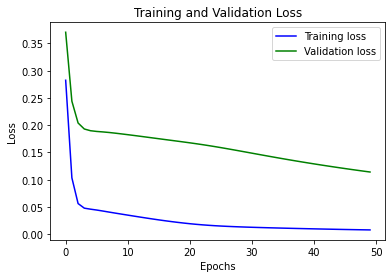

In [37]:
# defining a function to visualise the training and validation loss
def visualising_loss(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, 'blue', label = 'Training loss')
  plt.plot(epochs, val_loss, 'green', label = 'Validation loss')
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

visualising_loss(history, 'Training and Validation Loss')

In [ ]:
## We would need more time to carry out a Multi-stage series prediction